<a href="https://colab.research.google.com/github/Se-Boruk/Ucz_nienadzorowane_projekt/blob/Clustering-v0.1/Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
from DataBase.DataBase_Functions import Custom_DataSet_Manager as DB
from DataBase.DataBase_Functions import Custom_DataSet_Manager as DB
import Config as con
from datasets import load_dataset
import torch
import torch.nn.functional as F
from InPainter.Architectures import Encoder_v0
from torch.utils.data import DataLoader
import os
from sklearn.decomposition import PCA
import hdbscan
from collections import Counter




In [61]:
manager = DB(
    DataSet_path=r'C:\Users\jakub\Desktop\Repozytoria Github\Databases\Uczenie ze wzmocnieniem',
    train_split=0.7,
    val_split=0.15,
    test_split=0.15,
    random_state=259189
    )

# Nowa sekcja

In [62]:
manager.download_database("Artificio/WikiArt_Full")

Dataset is alredy downloaded!


In [63]:
train, val, test = manager.load_dataset_from_disk()

print(train[0])  # Przykładowy rekord
print(len(train), len(val), len(test))

{'style': 'Rococo', 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x7A2E35960530>}
72274 15488 15488


In [64]:
style_count = Counter(train["style"])
style_count = dict(style_count)
print(style_count)
print(len(style_count))


{'Rococo': 1910, 'Baroque': 3022, 'Art Nouveau (Modern)': 3429, 'Luminism': 281, 'Realism': 7352, 'Neo-Expressionism': 300, 'Romanticism': 6501, 'Surrealism': 2917, 'Ink and wash painting': 372, 'Art Informel': 895, 'Color Field Painting': 636, 'Post-Impressionism': 4050, 'Impressionism': 7489, 'Sōsaku hanga': 243, 'Mannerism (Late Renaissance)': 934, 'Contemporary Realism': 219, 'Concretism': 405, 'Ukiyo-e': 1003, 'Early Renaissance': 980, 'Divisionism': 241, 'Lyrical Abstraction': 460, 'Expressionism': 4972, 'Orientalism': 273, 'Abstract Expressionism': 1424, 'Shin-hanga': 279, 'Neoclassicism': 1428, 'Northern Renaissance': 1683, 'Romanesque': 40, 'Pop Art': 529, 'Symbolism': 2454, 'Metaphysical art': 144, 'Tenebrism': 155, 'Naïve Art (Primitivism)': 1604, 'Japonism': 85, 'High Renaissance': 935, 'Proto Renaissance': 195, 'Naturalism': 298, 'Abstract Art': 678, 'Neo-baroque': 75, 'Fauvism': 504, 'Magic Realism': 720, 'Regionalism': 230, 'Social Realism': 216, 'Op Art': 372, 'Ottoman 

In [65]:
# style_count is a dict mapping style -> count
for i in style_count:
    print(i, style_count[i])

Rococo 1910
Baroque 3022
Art Nouveau (Modern) 3429
Luminism 281
Realism 7352
Neo-Expressionism 300
Romanticism 6501
Surrealism 2917
Ink and wash painting 372
Art Informel 895
Color Field Painting 636
Post-Impressionism 4050
Impressionism 7489
Sōsaku hanga 243
Mannerism (Late Renaissance) 934
Contemporary Realism 219
Concretism 405
Ukiyo-e 1003
Early Renaissance 980
Divisionism 241
Lyrical Abstraction 460
Expressionism 4972
Orientalism 273
Abstract Expressionism 1424
Shin-hanga 279
Neoclassicism 1428
Northern Renaissance 1683
Romanesque 40
Pop Art 529
Symbolism 2454
Metaphysical art 144
Tenebrism 155
Naïve Art (Primitivism) 1604
Japonism 85
High Renaissance 935
Proto Renaissance 195
Naturalism 298
Abstract Art 678
Neo-baroque 75
Fauvism 504
Magic Realism 720
Regionalism 230
Social Realism 216
Op Art 372
Ottoman Period 47
Neo-Romanticism 372
Muralism 95
Tachisme 311
Academicism 670
Cubism 1202
Biedermeier 86
None 697
Pointillism 330
Mechanistic Cubism 53
New European Painting 20
Socialis

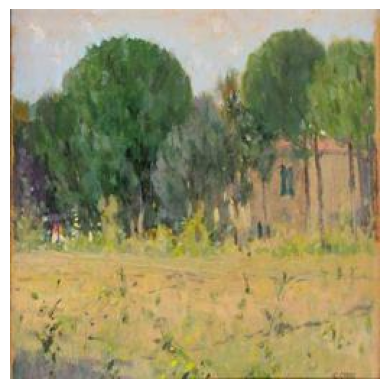

{'style': 'Impressionism', 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x7A2E35934680>}


In [66]:
from PIL import Image
import matplotlib.pyplot as plt

number = 55

sample = train[number]["image"]  # To już jest obiekt PIL.Image
plt.imshow(sample)
plt.axis("off")
plt.show()
print(train[number])

In [67]:
unique_styles = len(set(train["style"]))
print(unique_styles)

134


In [68]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Uruchomione na:", device)

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")

Uruchomione na: cuda
PyTorch version: 2.9.0+cu126
CUDA available: True
CUDA device: Tesla T4


In [69]:
import os

torch.set_num_threads(os.cpu_count())
print("Using CPU threads:", torch.get_num_threads())

Using CPU threads: 2


In [70]:
checkpoint = torch.load("best_inpainter.pth", map_location=device)
full_state = checkpoint["encoder_state_dict"]

In [71]:
encoder = Encoder_v0(input_channels=3, base_filters=32).to(device)
encoder_state = encoder.state_dict()     # klucze z encodera

In [72]:
filtered_state = {
    k: v for k, v in full_state.items()
    if k in encoder_state
}

In [73]:
encoder_state.update(filtered_state)
encoder.load_state_dict(encoder_state)
encoder.eval()

Encoder_v0(
  (input_conv_block): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (enc_0): Processing_Block(
    (conv_1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm_1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (act_1): LeakyReLU(negative_slope=0.2, inplace=True)
    (conv_21): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16)
    (norm_21): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (conv_22): Conv2d(16, 16, kernel_size=(1, 1), stri

In [74]:
import torchvision.transforms as T
import numpy as np
import time

transform = T.Compose([
    T.ToTensor(),                         # [0,1]
    T.Normalize([0.5]*3, [0.5]*3)         # [-1,1]
])

def collate_fn_images_only(batch):
    images = [transform(item['image']) for item in batch]
    return torch.stack(images)

BATCH_SIZE = 32  # Dostosuj tę wartość do dostępnej pamięci VRAM/RAM
NUM_WORKERS = 4  # Dostosuj do liczby rdzeni CPU

test_dataloader = DataLoader(
    dataset=train,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn_images_only
    # lambda x: [torch.stack([transform(item['image']) for item in x])]
)

i = 0
features_list = []
start = time.time()

# Iteracja po DataLoaderze, który dostarcza już wsady (batches)
for batch_images in test_dataloader:
    batch_images = batch_images.to(device)  # Przenieś wsad na urządzenie

    with torch.no_grad():
        features = encoder(batch_images) # (B,C,H',W')

    # Global Average Pooling do (B, 128, 1, 1)
    features_pooled = F.adaptive_avg_pool2d(features, (1, 1))
    # spłaszcz do 1D (B, 128)
    features_flat = features_pooled.cpu().numpy().squeeze()


    if BATCH_SIZE == 1:
        # Rozszerz features_list o cechy z całego wsadu
        features_list.append(features_flat)
    else:
        # Rozszerzenie listy o wszystkie wektory cech z wsadu
        features_list.extend(features_flat)

    i += BATCH_SIZE
    if i % 3200 == 0:
        print(f"Przetworzono {i} obrazów w czasie {(time.time() - start)/60:.2f} minut")

time_elapsed = time.time() - start
print(f"Całkowity czas przetwarzania {i} obrazów: {time_elapsed/60:.2f} minut")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Przetworzono 3200 obrazów w czasie 0.45 minut
Przetworzono 6400 obrazów w czasie 0.87 minut
Przetworzono 9600 obrazów w czasie 1.28 minut
Przetworzono 12800 obrazów w czasie 1.70 minut
Przetworzono 16000 obrazów w czasie 2.13 minut
Przetworzono 19200 obrazów w czasie 2.55 minut
Przetworzono 22400 obrazów w czasie 2.97 minut
Przetworzono 25600 obrazów w czasie 3.39 minut
Przetworzono 28800 obrazów w czasie 3.81 minut
Przetworzono 32000 obrazów w czasie 4.23 minut
Przetworzono 35200 obrazów w czasie 4.65 minut
Przetworzono 38400 obrazów w czasie 5.08 minut
Przetworzono 41600 obrazów w czasie 5.50 minut
Przetworzono 44800 obrazów w czasie 5.92 minut
Przetworzono 48000 obrazów w czasie 6.35 minut
Przetworzono 51200 obrazów w czasie 6.77 minut
Przetworzono 54400 obrazów w czasie 7.19 minut
Przetworzono 57600 obrazów w czasie 7.61 minut
Przetworzono 60800 obrazów w czasie 8.04 minut
Przetworzono 64000 obrazów w czasie 8.48 minut
Przetworzono 67200 obrazów w czasie 8.90 minut
Przetworzono 704

In [75]:
print(features_flat.shape)
print(features_flat.reshape(1,-1).shape)
print(f"({len(features_list)}, {len(features_list[0])})")


(18, 128)
(1, 2304)
(72274, 128)


In [76]:
print(len(test["image"]))
print(len(features_list))
np_features_list = np.array(features_list)

15488
72274


In [77]:
pca = PCA(n_components=30)
X_reduced = pca.fit_transform(features_list)


clusterer = hdbscan.HDBSCAN(
    min_cluster_size=20,       # minimalny rozmiar klastra
    min_samples=1             # bardziej konserwatywny = mniej szumu
)

labels = clusterer.fit_predict(X_reduced)   # shape (N,)

print(labels)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[22 -1 -1 ... 22 -1 -1]


{np.int64(22): 43093, np.int64(-1): 28354, np.int64(21): 40, np.int64(8): 37, np.int64(13): 31, np.int64(6): 30, np.int64(5): 22, np.int64(18): 77, np.int64(4): 34, np.int64(9): 49, np.int64(12): 24, np.int64(19): 26, np.int64(17): 46, np.int64(20): 22, np.int64(10): 63, np.int64(1): 50, np.int64(15): 75, np.int64(11): 20, np.int64(2): 23, np.int64(14): 20, np.int64(7): 58, np.int64(16): 27, np.int64(0): 25, np.int64(3): 28}


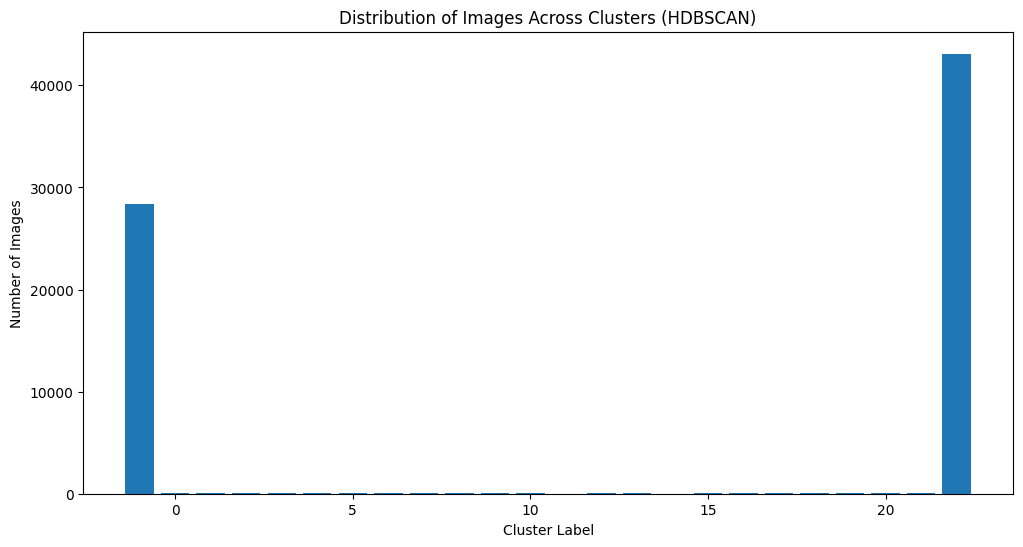

In [78]:
counts = dict(Counter(labels))


print(counts)
X = [i for i in counts]
Y = [i for i in counts.values()]

plt.figure(figsize=(12, 6))
plt.title("Distribution of Images Across Clusters (HDBSCAN)")
plt.xlabel("Cluster Label")
plt.ylabel("Number of Images")
plt.bar(X, Y)
plt.show()

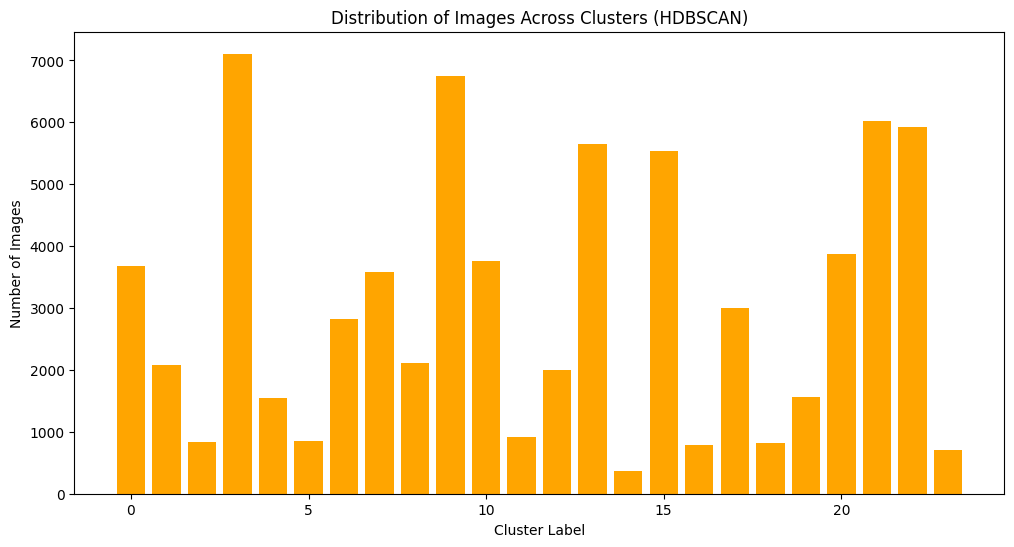

In [79]:
from sklearn.cluster import MiniBatchKMeans
# Używamy liczby unikalnych stylów (np. 134 z Cell 8) jako K
K = len(counts)  # Proszę dostosować
kmeans = MiniBatchKMeans(
    n_clusters=K,
    random_state=42,
    batch_size=256,
    n_init='auto' # Automatyczne wybieranie liczby inicjalizacji
)
labels_kmeans = kmeans.fit_predict(X_reduced)

counts = dict(Counter(labels_kmeans))

X = [i for i in counts]
Y = [i for i in counts.values()]

plt.figure(figsize=(12, 6))
plt.title("Distribution of Images Across Clusters (HDBSCAN)")
plt.xlabel("Cluster Label")
plt.ylabel("Number of Images")
plt.bar(X, Y, color='orange')
plt.show()

/tmp/ipython-input-1833275376.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Spectral')


Generowanie wykresu 3D...


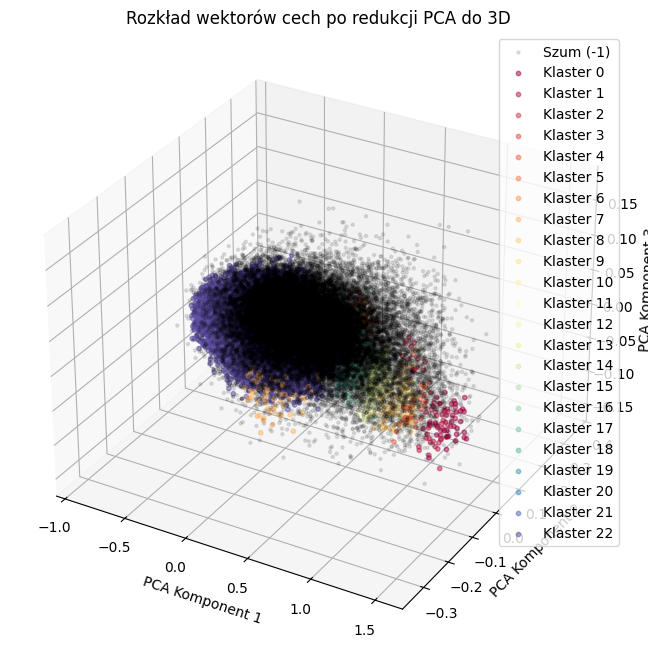

Wykres został zapisany jako 'cechy_3d_pca.png'


In [80]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 1. Zredukuj wymiarowość do 3 komponentów
# Zakładamy, że 'features_list' jest tablicą NumPy (N, 128)
pca_3d = PCA(n_components=3)
X_3D = pca_3d.fit_transform(features_list)

# Opcjonalnie: Załaduj etykiety klastrów, jeśli zostały już obliczone (z Cell 24)
# Użyjemy ich do kolorowania punktów. Etykiety szumu (-1) zostaną pokolorowane na czarno.
try:
    labels = np.array(labels) # Etykiety z HDBSCAN
    unique_labels = np.unique(labels)
    # Tworzenie mapy kolorów
    cmap = plt.cm.get_cmap('Spectral')
    # Normalizacja dla kolorów (pomijamy -1, które będzie czarne)
    norm = plt.Normalize(vmin=0, vmax=len(unique_labels) - 2)
except NameError:
    # Jeśli labels nie jest zdefiniowane, użyj prostego koloru
    labels = np.zeros(X_3D.shape[0])
    unique_labels = [0]
    cmap = plt.cm.get_cmap('viridis')
    norm = plt.Normalize(vmin=0, vmax=0)

# 2. Wizualizacja 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

print("Generowanie wykresu 3D...")

for label in unique_labels:
    if label == -1:
        # Punkty sklasyfikowane jako szum (outliers) - kolor czarny
        mask = (labels == -1)
        ax.scatter(X_3D[mask, 0], X_3D[mask, 1], X_3D[mask, 2],
                   c='black', label='Szum (-1)', alpha=0.1, s=5)
    else:
        # Punkty należące do klastra
        mask = (labels == label)
        ax.scatter(X_3D[mask, 0], X_3D[mask, 1], X_3D[mask, 2],
                   c=[cmap(norm(label))], label=f'Klaster {label}', alpha=0.5, s=10)

ax.set_title('Rozkład wektorów cech po redukcji PCA do 3D')
ax.set_xlabel('PCA Komponent 1')
ax.set_ylabel('PCA Komponent 2')
ax.set_zlabel('PCA Komponent 3')

# Ze względu na dużą liczbę punktów, legenda może być nieczytelna.
# Jeśli zależy Panu na legendzie, proszę ją odkomentować.
ax.legend()
plt.show()

# Zapisz wykres do pliku PNG
fig.savefig('cechy_3d_pca.png')
print("Wykres został zapisany jako 'cechy_3d_pca.png'")

In [81]:
labels_kmeans

array([13, 19, 16, ...,  3, 17, 22], dtype=int32)

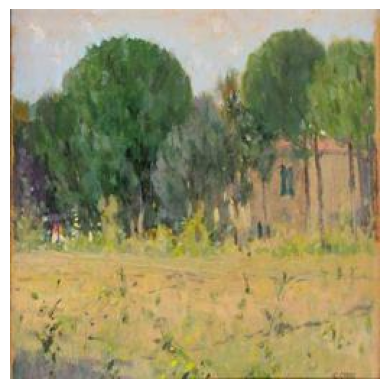

{'style': 'Impressionism', 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x7A2E28343F20>}


In [83]:
number = 55

sample = train[number]["image"]  # To już jest obiekt PIL.Image
plt.imshow(sample)
plt.axis("off")
plt.show()
print(train[number])

In [ ]:
for id, label in enumerate(labels_kmeans):


In [86]:
labels_kmeans

array([13, 19, 16, ...,  3, 17, 22], dtype=int32)